**Question 1**
* Gabriel Cutshaw
* Dante Goldner
* Mattan Tseng
* Hossen Zaremehrjerdi


In [29]:
import numpy as np
import h5py
from einops import rearrange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import time
import datetime

print(torch.__version__)


2.0.0


In [30]:
data_path = "./Combustion_data_ME592_Assignment/Aditya_data/combustion_img_13.mat"
arrays = {}


data = h5py.File(data_path)

for k, v in data.items():
    arrays[k] = np.array(v)


test_set_x = arrays["test_set_x"]
test_set_y = arrays["test_set_y"]
train_set_x = arrays["train_set_x"]
train_set_y = arrays["train_set_y"]
valid_set_x = arrays["valid_set_x"]
valid_set_y = arrays["valid_set_y"]

In [31]:
print(type(arrays))
#print(arrays)

print("The shape of test x: ", test_set_x.shape)
print("The shape of test y: ", test_set_y.shape)
print("The shape of train x: ", train_set_x.shape)
print("The shape of train y: ", train_set_y.shape)
print("The shape of validation x: ", valid_set_x.shape)
print("The shape of validation y: ", valid_set_y.shape)

<class 'dict'>
The shape of test x:  (25000, 18000)
The shape of test y:  (18000, 1)
The shape of train x:  (25000, 54000)
The shape of train y:  (54000, 1)
The shape of validation x:  (25000, 9000)
The shape of validation y:  (9000, 1)


shape of test array:  (18000, 100, 250)
shape of train array:  (54000, 100, 250)
shape of validation array:  (9000, 100, 250)
This image is labeled:  [1]  (stable)


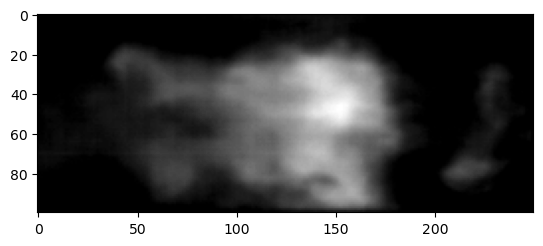

In [32]:
image_shape = (250, 100)

# all of our arrays are strangely formatted. 
# rearrange them to be individual images. 

# test set is not used at all in training. 
test_images = rearrange(test_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
# train set is used to actually train the model
train_images = rearrange(train_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
# train_labels = rearrange(train_set_y, "x y -> y x")
# validation set is used to avoid overfitting 
validation_images = rearrange(valid_set_x, "(x y) i -> i y x", x = image_shape[0], y = image_shape[1])
print("shape of test array: ", test_images.shape)
print("shape of train array: ", train_images.shape)
print("shape of validation array: ", validation_images.shape)


plt.imshow(train_images[0, :, :], cmap="gist_gray")
print("This image is labeled: ", test_set_y[0], " (stable)")

# plt.imshow(np.zeros((10, 10)), cmap="Greys")


This image is labeled:  [0]  (unstable)
0
255


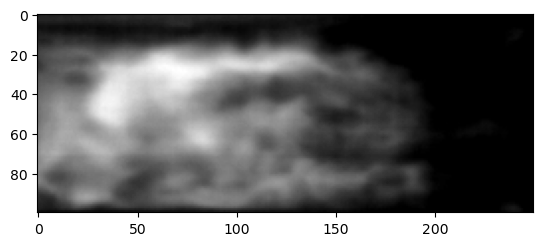

In [33]:
plt.imshow(test_images[2000, :, :], cmap='gist_gray')
print("This image is labeled: ", test_set_y[2000], " (unstable)")
print(np.min(test_images[2000, :, :]))
print(np.max(test_images[2000, :, :]))

Text(0, 0.5, 'instances')

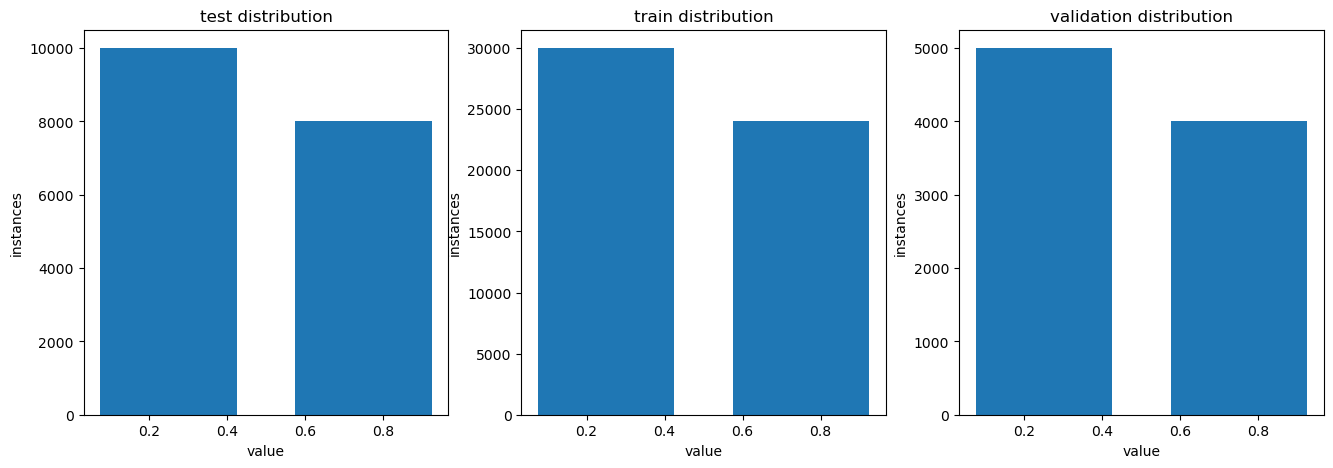

In [34]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
ax[0].set_title("test distribution")
ax[0].hist(test_set_y, bins = 2, rwidth = 0.7)
ax[0].set_xlabel("value")
ax[0].set_ylabel("instances")

ax[1].set_title("train distribution")
ax[1].hist(train_set_y, bins = 2, rwidth = 0.7)
ax[1].set_xlabel("value")
ax[1].set_ylabel("instances")


ax[2].set_title("validation distribution")
ax[2].hist(valid_set_y, bins = 2, rwidth = 0.7)
ax[2].set_xlabel("value")
ax[2].set_ylabel("instances")


In [35]:
# now that our data preparation is complete, we can start setting up our CNN
# Input: Image
# Output: Stable/Unstable (1 or 0)

# these are the hyperparameters for the model
# remember that a batch is how many items the  model will train on before updating the model
batch_size = 4
# remember that an epoch is the number of times that the trainer will go through the entire dataset
epochs = 1 
# since our image is rectangular, let's use a rectangular kernel. 
# this touple is comprised of factors of the dimensions. 
kernel_size = (25, 10) 
input_height = train_images[0].shape[0]
input_width = train_images[0].shape[1]


stride = 1
classes = ("stable", "unstable")
number_channels = 1 # this is a grayscale image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# to increase the speed of the training, make sure that the GPU is being used. 
print(torch.cuda.is_available())


print("Number of epochs: ", epochs)
print("Batch size: ", batch_size)
print("Kernel size: ", kernel_size)
print("Stride size: ", stride)
print("Classes: ", classes)
print("input height: ", input_height)
print("input width: ", input_width)
print("device type: ", device)
# print("The device being used is: ", device)

True
Number of epochs:  1
Batch size:  4
Kernel size:  (25, 10)
Stride size:  1
Classes:  ('stable', 'unstable')
input height:  100
input width:  250
device type:  cuda


In [36]:
# Define the CNN architecture

# These links were used for reference 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
# for a test, let's train this first without using the validation set. 
# that way we can prove that the validation set actually does help increase accuracy and decrease overfitting
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)
        # self.fc1 = nn.Linear(800, 64)
        self.fc1 = nn.Linear(89792, 1000)
        self.fc2 = nn.Linear(1000, 2)


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))

        # num_flat_features = x.size(1)*x.size(2)*x.size(3)
        # x = x.view(-1, num_flat_features)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x




In [37]:
# Define the training loop
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Define the validation loop
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

# Define the test loop
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy


In [38]:
# we need to convert our numpy arrays into pytorch tensors
batch_size = 4

train_images_torch = torch.div(torch.from_numpy(train_images).float(), 255)
train_labels_torch = torch.from_numpy(train_set_y).float()
train_dataset = torch.utils.data.TensorDataset(train_images_torch, train_labels_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)



validation_images_torch = torch.div(torch.from_numpy(validation_images).float(), 255)
validation_labels_torch = torch.from_numpy(valid_set_y).float()
validation_dataset = torch.utils.data.TensorDataset(validation_images_torch, validation_labels_torch)
validation_loader =  torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

# test_images_torch = torch.div(torch.from_numpy(test_images).float(), 255)
# test_labels_torch = torch.from_numpy(test_set_y).float()
# validation_images_torch = torch.div(torch.from_numpy(validation_images).float(), 255)
# validation_labels_torch = torch.from_numpy(valid_set_y).float()
# create the dataloaders from our tensors. 
# train_loader = torch.utils.data.TensorDataset(train_images_torch, train_set_y)
# val_loader = torch.utils.data.TensorDataset(validation_images_torch, validation_labels_torch)
# test_loader = torch.utils.data.TensorDataset(test_images_torch, test_labels_torch)
# val_loader = torch.utils.data.DataLoader(val_loader, batch_size=batch_size, shuffle=False, num_workers=6) 
# test_loader = torch.utils.data.DataLoader(test_loader, batch_size=batch_size, shuffle=False, num_workers=6)
cnn = CNN()
cnn.to(device)
print(cnn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
losses = []
for epoch in range(epochs):
    cnn.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = rearrange(inputs, "(c b) h w -> b c h w", c = 1)
        # labels = rearrange(labels, "x y -> y x")
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)

        # print("The type of labels is: ", type(labels))
        # print("The shape of labels is: ", labels.size())
        # print("labels: ", labels)
        # print("The type of outputs is: ", type(outputs))
        # print("The shape of outputs is: ", outputs.size())
        # print("outputs: ", outputs)
        #criterion expects to recieve the index of the correct label. 
        # our labels are currently one hot encoded
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print("epoch: ", epoch+1, "batch: ", i+1, "Loss: ", running_loss)
            losses.append(running_loss)
            running_loss = 0.0



end_time = time.time()
train_time = end_time - start_time
print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
print('Finished Training')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89792, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)
epoch:  1 batch:  1000 Loss:  6.172994668253523
epoch:  1 batch:  2000 Loss:  0.03190486424000483
epoch:  1 batch:  3000 Loss:  0.01929974971289994
epoch:  1 batch:  4000 Loss:  0.013404405419350951
epoch:  1 batch:  5000 Loss:  0.010483780886829663
epoch:  1 batch:  6000 Loss:  0.008176467810926624
epoch:  1 batch:  7000 Loss:  0.0070349661889395065
epoch:  1 batch:  8000 Loss:  0.006116083845199682
epoch:  1 batch:  9000 Loss:  0.00520813513929852
epoch:  1 batch:  10000 Loss:  0.004531688698193648
epoch:  1 batch:  11000 Loss:  0.004077864145301646
epoch:  1 batch:  12000 Loss:  0.0037919124853260655
epoch:  1 batch:  13000 Loss:  0.00336011019936677

In [46]:
testImage, testLabel = next(iter(validation_loader))

print("Type of testImage: ", type(testImage))
print("Type of testLabel: ", type(testLabel))

Type of testImage:  <class 'torch.Tensor'>
Type of testLabel:  <class 'torch.Tensor'>


In [39]:
# we need to convert our numpy arrays into pytorch tensors
batch_size = 4

# prepare teh training set
train_images_torch = torch.div(torch.from_numpy(train_images).float(), 255)
train_labels_torch = torch.from_numpy(train_set_y).float()


# prepare the validation set
validation_images_torch = torch.div(torch.from_numpy(validation_images).float(), 255)
validation_labels_torch = torch.from_numpy(valid_set_y).float()


cnn = CNN()
cnn.to(device)
print(cnn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
all_train_loss = []
all_validation_loss = []
for epoch in range(3):
    cnn.train()
    running_loss = 0.0
    # Prepare test set
    train_set_image = Variable(train_images_torch).to(device)
    train_set_image = rearrange(train_set_image, "(c b) h w -> b c h w", c = 1)
    train_set_labels = Variable(train_labels_torch).to(device)    
    
    # prepare validation set
    validation_set_image = Variable(validation_images_torch).to(device)
    validation_set_image = rearrange(validation_set_image, "(c b) h w -> b c h w", c = 1) # this is clunky. move this step to the beginning
    validation_set_labels = Variable(validation_labels_torch).to(device)


        
    # zero the parameter gradients
    optimizer.zero_grad()

    train_output = cnn(train_set_image)
    validation_output = cnn(validation_set_image)

    train_loss = criterion(train_output, train_set_labels)
    validation_loss = criterion(validation_output, validation_set_labels)
    all_train_loss.append(train_loss)
    all_validation_loss.append(validation_loss)

    train_loss.backward()
    optimizer.step()

    if i % 1000 == 999:    # print every 2000 mini-batches
        print(f'[epoch: {epoch + 1} loss: {running_loss / 2000:.3f}')
        losses.append(running_loss)
        running_loss = 0.0



end_time = time.time()
train_time = end_time - start_time
print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
print('Finished Training')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89792, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.03 GiB (GPU 0; 12.00 GiB total capacity; 7.22 GiB already allocated; 2.40 GiB free; 7.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

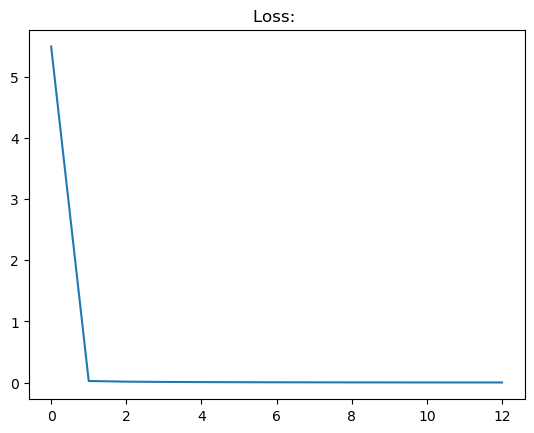

In [ ]:

plt.title("Loss: ")
plt.plot(losses)


In [ ]:
print(inputs.size())
print()
print(torch.max(labels, 1)[1])
print(outputs)

torch.Size([4, 1, 100, 250])

tensor([0, 0, 0, 0], device='cuda:0')
tensor([[ 6.5562, -5.8929],
        [ 7.1736, -6.4377],
        [ 7.0843, -6.3604],
        [ 6.3594, -5.7096]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
image1 = train_dataset[10][:][0].numpy()
# print(image1)
print(image1.shape)
print(image1.mean())
print(np.max(image1))
print(np.min(image1))

# plt.imshow(image1)



(100, 250)
0.24803813
1.0
0.0


In [ ]:
cnn = CNN()
PATH = './cifar_net.pth'
torch.save(cnn.state_dict(), PATH)
print("Saved")

Saved


In [ ]:
batch_size = 4
test_images_torch = torch.div(torch.from_numpy(test_images).float(), 255)
print("type(test_images): ", type(test_images_torch))

test_images_torch = torch.from_numpy(test_set_y).float()
# print("shape of labels: ", len(train_labels_torch))

test_dataset = torchvision.datasets.CIFAR10(test_images, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#train_dataset = torch.utils.data.TensorDataset(train_images_torch, train_labels_torch)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
# test_images_torch = torch.div(torch.from_numpy(test_images).float(), 255)
# test_labels_torch = torch.from_numpy(test_set_y).float()
# validation_images_torch = torch.div(torch.from_numpy(validation_images).float(), 255)
# validation_labels_torch = torch.from_numpy(valid_set_y).float()
# create the dataloaders from our tensors. 
# train_loader = torch.utils.data.TensorDataset(train_images_torch, train_set_y)
# val_loader = torch.utils.data.TensorDataset(validation_images_torch, validation_labels_torch)
# test_loader = torch.utils.data.TensorDataset(test_images_torch, test_labels_torch)
# val_loader = torch.utils.data.DataLoader(val_loader, batch_size=batch_size, shuffle=False, num_workers=6) 
# test_loader = torch.utils.data.DataLoader(test_loader, batch_size=batch_size, shuffle=False, num_workers=6)


dataiter = iter(testloader)
images, labels = next(dataiter)

type(test_images):  <class 'torch.Tensor'>


NameError: name 'transform' is not defined

In [ ]:
test1 = np.random.rand(10)
test2 = np.random.rand(10)
print(test1)

for i, result1, result2 in enumerate(test1), enumerate(test2):
    print(result1, "\t", result2)

[0.87840628 0.24927536 0.66046346 0.08915709 0.08713035 0.90142626
 0.40122718 0.93594997 0.51206452 0.403202  ]


ValueError: too many values to unpack (expected 3)